## Identifying Duplicate Questions

Over 100 million people visit Quora every month, so it's no surprise that many people ask similar (or the same) questions. Various questions with the same intent can cause people to spend extra time searching for the best answer to their question, and results in members answering multiple versions of the same question. Quora uses random forest to identify duplicated questions to provide a better experience to active seekers and writers, and offer more value to both of these groups in the long term.
Follow the steps outlined below to build the appropriate classifier model. 


Steps:
- Download data
- Exploration
- Cleaning
- Feature Engineering
- Modeling

By the end of this project you should have **a presentation that describes the model you built** and its **performance**. 


In [225]:
import pandas as pd
import numpy  as np
from matplotlib import pyplot as plt
import seaborn as sns

In [226]:
df = pd.read_csv("data/train.csv")

#### Note
There is no designated test.csv file. The train.csv file is the entire dataset. Part of the data in the train.csv file should be set aside to act as the final testing data.

### Exploration

In [227]:
df

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0
...,...,...,...,...,...,...
404285,404285,433578,379845,How many keywords are there in the Racket prog...,How many keywords are there in PERL Programmin...,0
404286,404286,18840,155606,Do you believe there is life after death?,Is it true that there is life after death?,1
404287,404287,537928,537929,What is one coin?,What's this coin?,0
404288,404288,537930,537931,What is the approx annual cost of living while...,I am having little hairfall problem but I want...,0


In [228]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


In [229]:
df.isnull().sum()

id              0
qid1            0
qid2            0
question1       1
question2       2
is_duplicate    0
dtype: int64

In [230]:
# Drop nulls
df.dropna(subset=['question1', 'question2'], inplace=True)

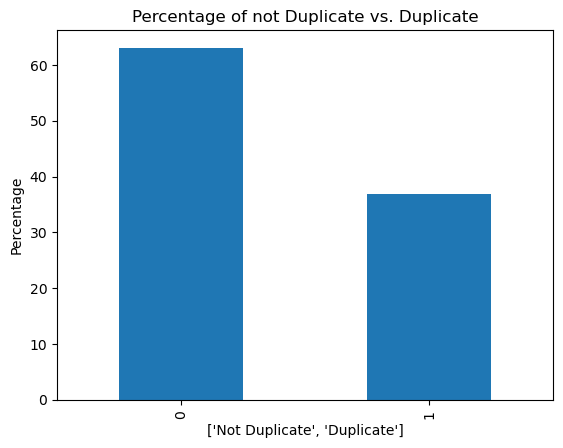

In [231]:
#Plot duplicate and no duplicate questions 
(df['is_duplicate'].value_counts()/df['is_duplicate'].count()*100).plot(kind='bar')
plt.title('Percentage of not Duplicate vs. Duplicate')
plt.ylabel('Percentage')
plt.xlabel(['Not Duplicate', 'Duplicate'])
plt.show()

In [232]:
#Count duplicate and non-duplicate questions
print(df['is_duplicate'].value_counts())

0    255024
1    149263
Name: is_duplicate, dtype: int64


### Cleaning

- Tokenization
- Stopwords cleaning
- Removing punctuation
- Normalizing
- Stemming

In [233]:
# Import pakages
from nltk.tokenize import word_tokenize
import string
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from nltk.stem.porter import PorterStemmer


#Apply data tokenization, lower casing, stopwords cleaning, and stemming
def data_cleaning(df):
    df_clean = df
    stop_words = set(stopwords.words('english'))
    porter = PorterStemmer()
    
    # Text transformation
    def transform(text):
        # split into words
        tokens = word_tokenize(text)
        # convert to lower case
        tokens = [w.lower() for w in tokens]
        # remove punctuation from each word
        table = str.maketrans('', '', string.punctuation)
        stripped = [w.translate(table) for w in tokens]
        # remove remaining tokens that are not alphabetic
        words = [word for word in stripped if word.isalpha()]
        # filter out stop words
        words = [w for w in words if not w in stop_words]
        return words

    df_clean['question1_clean'] = df_clean['question1'].apply(lambda x:[porter.stem(word) for word in transform(x)])
    df_clean['question2_clean'] = df_clean['question2'].apply(lambda x:[porter.stem(word) for word in transform(x)])

    return df_clean

In [234]:
df_clean = data_cleaning(df)
df_clean.head()

,id,qid1,qid2,question1,question2,is_duplicate,question1_clean,question2_clean
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,"[step, step, guid, invest, share, market, india]","[step, step, guid, invest, share, market]"
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,"[stori, kohinoor, kohinoor, diamond]","[would, happen, indian, govern, stole, kohinoo..."
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,"[increas, speed, internet, connect, use, vpn]","[internet, speed, increas, hack, dn]"
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,"[mental, lone, solv]","[find, remaind, math, math, divid]"
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,"[one, dissolv, water, quikli, sugar, salt, met...","[fish, would, surviv, salt, water]"


In [235]:
#Convert to string questions_clean
df_clean['question1_clean'] = df_clean['question1_clean'].apply(lambda x: ' '.join([str(elem) for elem in x]))
df_clean['question2_clean'] = df_clean['question2_clean'].apply(lambda x: ' '.join([str(elem) for elem in x]))

In [236]:
df_clean.head()

,id,qid1,qid2,question1,question2,is_duplicate,question1_clean,question2_clean
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,step step guid invest share market india,step step guid invest share market
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,stori kohinoor kohinoor diamond,would happen indian govern stole kohinoor kohi...
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,increas speed internet connect use vpn,internet speed increas hack dn
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,mental lone solv,find remaind math math divid
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,one dissolv water quikli sugar salt methan car...,fish would surviv salt water


In [237]:
df_clean['question1_clean']

0                  step step guid invest share market india
1                           stori kohinoor kohinoor diamond
2                    increas speed internet connect use vpn
3                                          mental lone solv
4         one dissolv water quikli sugar salt methan car...
                                ...                        
404285    mani keyword racket program languag latest ver...
404286                                    believ life death
404287                                             one coin
404288    approx annual cost live studi uic chicago indi...
404289                                      like sex cousin
Name: question1_clean, Length: 404287, dtype: object

In [238]:
df_clean2=df_clean.copy(deep=True)

### Feature Engineering

- tf-idf
- word2vec
- word count
- number of the same words in both questions
- ....

In [239]:
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec
from sklearn.metrics.pairwise import cosine_similarity

In [240]:
# TF-IDF Vectorizer
vectorized = TfidfVectorizer()
vectorized.fit(df_clean2['question1_clean'] + df_clean2['question2_clean'])
vect_q1 = vectorized.transform(df_clean2['question1_clean'])
vect_q2 = vectorized.transform(df_clean2['question2_clean'])

#Cosine of similarities
cosine_sim = []
for i in range(len(df_clean2)):       
        cosine_sim.append(cosine_similarity(vect_q1[i], vect_q2[i]))

In [ ]:
#Extract cosine from array and load it into df
cosine_sim2 = []
for item in cosine_sim:
    cosine_sim2.append(item [0][0])

df_clean2['cosine_sim'] = cosine_sim2

In [300]:
#Word count
df_clean2['word_count_q1'] = df_clean2['question1_clean'].apply(lambda x: len(word_tokenize(str(x)))) 
df_clean2['word_count_q2'] = df_clean2['question2_clean'].apply(lambda x: len(word_tokenize(str(x))))
#Matching words
df_clean2['matching_words'] = df_clean2.apply(lambda row: len(set(row['question1_clean'].split()) & set(row['question2_clean'].split())), axis=1)
df_clean2['percentage_matching_words'] = df_clean2['matching_words'] / ((df_clean2['question1_clean'].apply(lambda x: len(x.split())) + df_clean2['question2_clean'].apply(lambda x: len(x.split()))) / 2) 
df_clean2['percentage_matching_words'] = df_clean2['percentage_matching_words'].fillna(0)

In [301]:
df_clean2.head()

,id,qid1,qid2,question1,question2,is_duplicate,question1_clean,question2_clean,cosine_sim,word_count_q1,word_count_q2,matching_words,percentage_matching_words
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,step step guid invest share market india,step step guid invest share market,0.977544,7,6,5,0.769231
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,stori kohinoor kohinoor diamond,would happen indian govern stole kohinoor kohi...,0.812851,4,9,2,0.307692
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,increas speed internet connect use vpn,internet speed increas hack dn,0.460152,6,5,3,0.545455
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,mental lone solv,find remaind math math divid,0.000000,3,5,0,0.000000
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,one dissolv water quikli sugar salt methan car...,fish would surviv salt water,0.239805,10,5,2,0.266667


### Modeling

Different modeling techniques can be used:

- logistic regression
- XGBoost
- LSTMs
- etc

In [334]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn import metrics
import xgboost as xgb
from xgboost import XGBClassifier

In [303]:
#Split variables and samples of dataset
X = df_clean[['cosine_sim','word_count_q1','word_count_q2','matching_words','percentage_matching_words']]
y = df_clean['is_duplicate']

#Split test and training data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)

In [304]:
#Balance with SMOTE
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train, y_train)

print(X_res.shape)
y_res.value_counts()

(408142, 5)


0    204071
1    204071
Name: is_duplicate, dtype: int64

#### Logistict Regression

In [331]:
model_lr = LogisticRegression()
model_lr.fit (X_res,y_res)

y_lr_pred = model_lr.predict(X_test)
y_lr_pred_train = model_lr.predict(X_train)

In [332]:
print("Test Accuracy:", accuracy_score(y_test, y_lr_pred))
print("Training accuracy:", accuracy_score(y_train, y_lr_pred_train))

Test Accuracy: 0.6579188206485443
Training accuracy: 0.6587133497614623


In [335]:
#Confusion matrix
confusion = confusion_matrix(y_test, y_lr_pred)
print("Confusion matrix:\n", confusion)

Confusion matrix:
 [[31509 19444]
 [ 8216 21689]]


#### XgBoost

In [329]:
model_xgb = xgb.XGBClassifier(objective='binary:logistic', n_estimators=10, seed=15)
model_xgb.fit (X_res,y_res)

y_xgb_pred = model_xgb.predict(X_test)
y_xgb_pred_train = model_xgb.predict(X_train)

In [330]:
print("Test Accuracy:", accuracy_score(y_test, y_xgb_pred))
print("Training accuracy:", accuracy_score(y_train, y_xgb_pred_train))

Test Accuracy: 0.6693957307873062
Training accuracy: 0.6704037052954435


In [336]:
#Confusion matrix
confusion = confusion_matrix(y_test, y_xgb_pred)
print("Confusion matrix:\n", confusion)

Confusion matrix:
 [[28768 22185]
 [ 4547 25358]]
